In [3]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib as mpl
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
from scipy.stats import bootstrap
import statsmodels.api as sm
import statsmodels.formula.api as smf

params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "font.size": 12,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "text.usetex": False,
}

mpl.rcParams.update(params)


import warnings

warnings.filterwarnings("ignore")


In [4]:
df_time_series = pd.read_csv(
    "./data/df_timeseries_en.tsv.gz", compression="infer", sep="\t"
)
df_time_series["datetime"] = pd.to_datetime(df_time_series["datetime"])

df_channels = pd.read_csv("./data/df_channels_en.tsv.gz", compression="infer", sep="\t")
df_channels["join_date"] = pd.to_datetime(df_channels["join_date"])


In [5]:
video_metadatas = pd.read_feather(
    "./data/yt_metadata_helper.feather",
    columns=[
        "categories",
        "upload_date",
        "duration",
        "like_count",
        "dislike_count",
        "view_count",
        "channel_id",
    ],
)


In [6]:
# round the total number of subscribers, it is easier to consider 1 person and instead half of a person...
df_time_series.subs = df_time_series.subs.round(0)


In [8]:
df_time_series.head()


,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03,2.024946e+05,0.000000,650.0,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10,3.940857e+05,191591.111111,1046.0,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17,8.353938e+05,441308.083333,1502.0,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24,1.104577e+06,269183.250000,1750.0,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31,1.284406e+06,179828.600000,2008.0,258.300000,6,0,0


In [9]:
df_channels.head()


,category_cc,join_date,channel,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
0,Gaming,2010-04-29,UC-lHJZR3Gqxm24_Vd_AJ5Yw,PewDiePie,101000000,3956,3.0,2.087
1,Education,2006-09-01,UCbCmjCuTUZos6Inko4u57UQ,Cocomelon - Nursery ...,60100000,458,7.0,2.087
2,Entertainment,2006-09-20,UCpEhnqL0y41EpW2TvWAHD7Q,SET India,56018869,32661,8.0,2.087
3,Howto & Style,2016-11-15,UC295-Dw_tDNtZXFeAPAW6Aw,5-Minute Crafts,60600000,3591,9.0,2.087
4,Sports,2007-05-11,UCJ5v_MCY6GNUBTO8-D3XoAg,WWE,48400000,43421,11.0,2.087


In [10]:
video_metadatas.head()


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id
0,Film & Animation,2016-09-28,1159,8.0,1.0,1057.0,UCzWrhkg9eK5I8Bm3HfV-unA
1,Film & Animation,2016-09-28,2681,23.0,1.0,12894.0,UCzWrhkg9eK5I8Bm3HfV-unA
2,Film & Animation,2016-09-28,1394,1607.0,779.0,1800602.0,UCzWrhkg9eK5I8Bm3HfV-unA
3,Film & Animation,2016-09-28,5064,227.0,24.0,57640.0,UCzWrhkg9eK5I8Bm3HfV-unA
4,Film & Animation,2016-09-28,3554,105.0,13.0,86368.0,UCzWrhkg9eK5I8Bm3HfV-unA


# Check length of videos uploaded on YouTube between 2005-05-24 to 2019-11-20

An idea would be to use **cut** to match length of videos into discrete intervals 

In [11]:
video_metadatas.duration.describe()


count    7.292479e+07
mean     7.576761e+02
std      1.820111e+03
min      1.000000e+00
25%      1.340000e+02
50%      2.840000e+02
75%      6.980000e+02
max      3.601570e+05
Name: duration, dtype: float64

In [12]:
# To make it easier, we convert the lengths of videos,to minutes...
video_metadatas["duration_min"] = video_metadatas["duration"] / 60
video_metadatas.duration_min.describe()


count    7.292479e+07
mean     1.262794e+01
std      3.033518e+01
min      1.666667e-02
25%      2.233333e+00
50%      4.733333e+00
75%      1.163333e+01
max      6.002617e+03
Name: duration_min, dtype: float64

Text(0.5, 1.0, 'Duration of Videos in Minutes')

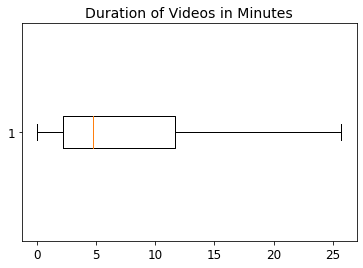

In [14]:
plt.boxplot(video_metadatas["duration_min"], showfliers=False, vert=False)
plt.title("Duration of Videos in Minutes")


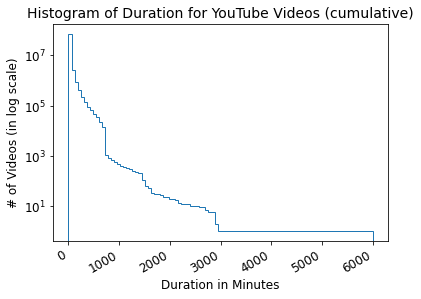

In [15]:
duration_min_cumul = plt.hist(
    video_metadatas.duration_min, bins=100, log=True, cumulative=-1, histtype="step"
)
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration in Minutes")
plt.xticks(rotation=30, ha="right")
plt.show()


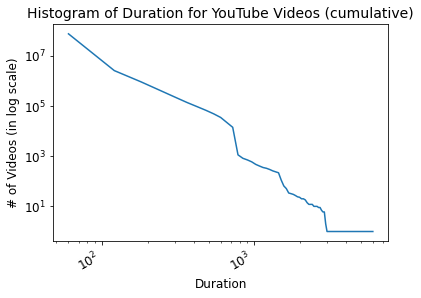

In [16]:
plt.loglog(duration_min_cumul[1][1:], duration_min_cumul[0])
plt.title("Histogram of Duration for YouTube Videos (cumulative)")
plt.ylabel("# of Videos (in log scale)")
plt.xlabel("Duration")
plt.xticks(rotation=30, ha="right")
plt.show()


In [13]:
# long to compute

# bucket_durations = pd.cut(video_metadatas['duration'], bins=100)
# print(type(bucket_durations))


---

# Check frequency of videos uploaded on YouTube between 2005-05-24 to 2019-11-20

In [17]:
video_count = (
    video_metadatas.groupby(pd.Grouper(key="upload_date", freq="W")).count().channel_id
)


Text(0.5, 1.0, 'Number of videos uploaded each week')

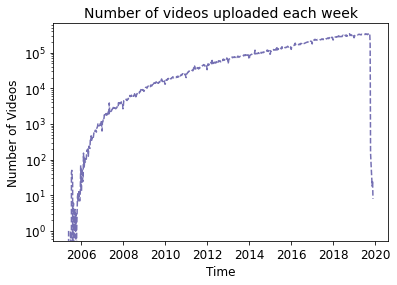

In [18]:
plt.plot(video_count, color="#7570b3", ls="--", label="\% videos uploaded")
plt.yscale("log")
plt.ylabel("Number of Videos")
plt.xlabel("Time")
plt.title("Number of videos uploaded each week")


In [20]:
# The following graph shows how many videos each channel uploads to YouTube per year.
video_metadatas["yearNumber"] = video_metadatas["upload_date"].dt.year
vd_cnt_by_id_yr = (
    video_metadatas.groupby(["channel_id", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_yr.columns.name = None


In [22]:
# We remove the channels that uploaded less than 12 videos throughout the study period. JUSTIFY WHY 12 OR DELAY / DELETE

vd_cnt_by_id_yr_filtered = vd_cnt_by_id_yr[vd_cnt_by_id_yr.sum(axis=1) > 12]


In [23]:
vd_cnt_by_id_yr_filtered_summary = vd_cnt_by_id_yr_filtered.describe()


Text(0.5, 1.0, 'The quantiles of yearly video upload frequency')

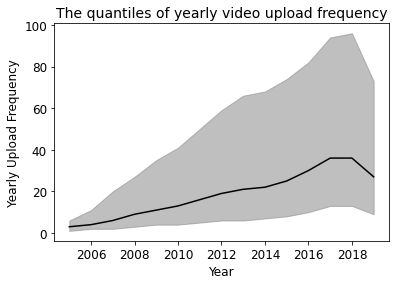

In [24]:
plt.fill_between(
    x=list(vd_cnt_by_id_yr_filtered_summary.columns.values),
    y1=list(vd_cnt_by_id_yr_filtered_summary.loc["25%", :]),
    y2=list(vd_cnt_by_id_yr_filtered_summary.loc["75%", :]),
    alpha=0.5,
    color="gray",
)
plt.plot(vd_cnt_by_id_yr_filtered_summary.loc["50%", :], color="black")

plt.xlabel("Year")
plt.ylabel("Yearly Upload Frequency")
plt.title("The 2nd and 3rd quartiles of yearly video upload frequency")
# here we choose quartiles, since the mean would be significantly affected by extremely high yearly upload rates


# Weekday Analysis

In [25]:
video_metadatas["weekNumber"] = video_metadatas["upload_date"].dt.weekday
vd_cnt_by_id_wk = (
    video_metadatas.groupby(["channel_id", "weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_id_wk.columns.name = None


In [26]:
vd_cnt_by_id_wk["mean_upload"] = vd_cnt_by_id_wk.iloc[:, 2:].mean(axis=1, skipna=True)


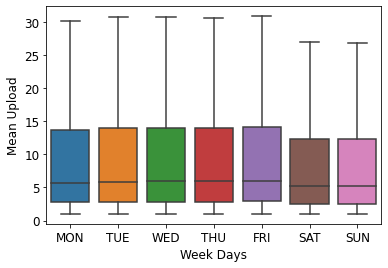

In [32]:
labels = ["MON", "TUE", "WED", "THU", "FRI", "SAT", "SUN"]
ax = sns.boxplot(
    x="weekNumber", y="mean_upload", data=vd_cnt_by_id_wk, showfliers=False
).set(
    xlabel='Week Days', 
    ylabel='Mean Upload',
    xticklabels= labels)


In [33]:
vd_cnt_by_wk = (
    video_metadatas.groupby(["weekNumber", "yearNumber"])
    .count()
    .categories.unstack()
    .reset_index()
)
vd_cnt_by_wk.columns.name = None


In [34]:
vd_cnt_by_wk_norm = vd_cnt_by_wk.iloc[:, 2:] / vd_cnt_by_wk.iloc[:, 2:].sum(skipna=True)


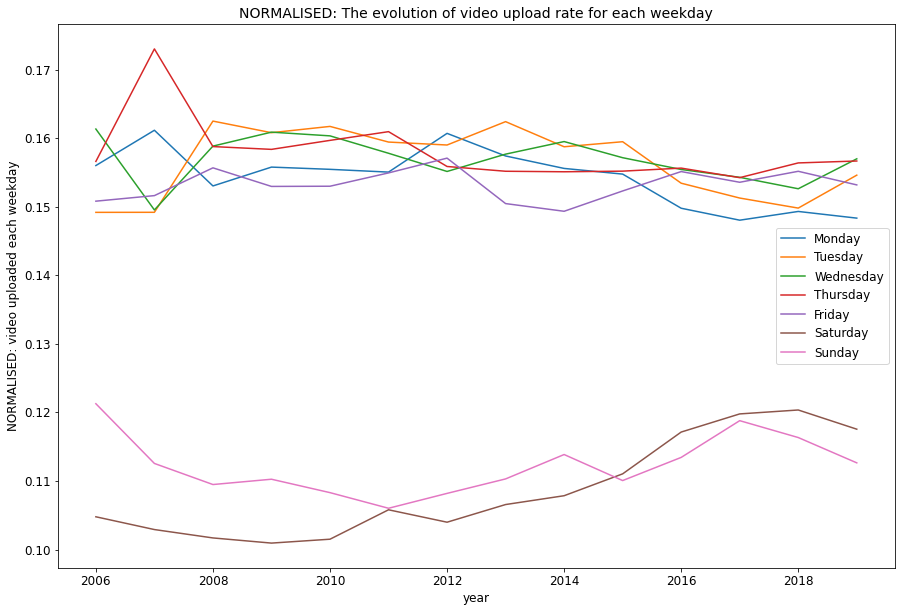

In [35]:
plt.rcParams["figure.figsize"] = (15, 10)
plt.plot(vd_cnt_by_wk_norm.T)
plt.legend(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
plt.xlabel("year")
plt.ylabel("NORMALISED: video uploaded each weekday")
plt.title("NORMALISED: The evolution of video upload rate for each weekday")
plt.show()


In [ ]:
# it seems that weekdays are prefered day to upload videos compared to weekends. However, which day of the week doesn't seem to matter too much.


---

# How long to reach 1M subscribers 

Could be interesting to take all the videos with 10K, 20K, 30K, ... and see the evolution to reach 100K for example. And compare different evolution : from 50K to 100K or from 500K to 600K, etc.. which one is the fastest, easiest ?  

In [20]:
def get_df_channel_ascension(start_subs, end_subs):
    """finds the channels in the time series that have less than the start_subs and more than end_subs.
    It means that it begins with less than start_subs and have now at least end_subs

    Args:
        start_subs (float): low_threshold
        end_subs (float): high_threshold

    Returns:
        dataframe containing all the channels with evolution from starts_subs to end_subs
    """
    under_start_subs = df_time_series[df_time_series["subs"] < start_subs]
    more_end_subs = df_time_series[df_time_series["subs"] > end_subs]
    channel_start_to_end = df_time_series[
        df_time_series.channel.isin(under_start_subs.channel)
        & df_time_series.channel.isin(more_end_subs.channel)
    ]
    return channel_start_to_end


In [21]:
def get_mean_time_to_reach_X_subs(df, lower_bound, upper_bound):
    time_to_reach_X_subs = df.groupby("channel").apply(
        lambda group: pd.Series(
            {
                "from_zero_to_hero_duration": group[group.subs > upper_bound][
                    "datetime"
                ].iloc[0]
                - group[group.subs < lower_bound]["datetime"].iloc[-1]
            }
        )
    )
    return time_to_reach_X_subs


In [22]:
channel_10K_to_1M = get_df_channel_ascension(10_000, 1_000_000)
print(
    "We have {} channels that begins with 10K subs and reach at least 1M".format(
        channel_10K_to_1M.channel.nunique()
    )
)


MemoryError: Unable to allocate 576. MiB for an array with shape (4, 18872499) and data type float64

In [ ]:
first_channel = channel_10K_to_1M.iloc[0]
test = channel_10K_to_1M[channel_10K_to_1M["channel"] == first_channel.channel]
# test = test[(test['datetime'] > np.datetime64('2018-07-20')) & (test['datetime'] < np.datetime64('2019-01-20'))]
test.plot(x="datetime", y="subs")
print("There are {} weeks for this channel".format(test.shape[0]))
print(
    "We should have approximately the same value : \n{} and {}".format(
        7 * test.shape[0], test.iloc[-1].datetime - test.iloc[0].datetime
    )
)


In [ ]:
# get the time it takes to go from less than 10K to 1M
time_to_reach_1M = get_mean_time_to_reach_X_subs(channel_10K_to_1M, 10_000, 1_000_000)
time_to_reach_1M.head()


In [ ]:
print(
    "In average YTbers take {} days to reach 1M of subscribers".format(
        time_to_reach_1M["from_zero_to_hero_duration"].mean().days
    )
)


It would be nice to bootstrap this result to see with interval of confidence the time taken by Youtuber to reach 1M

In [ ]:
data = time_to_reach_1M["from_zero_to_hero_duration"].apply(
    lambda delta_time: delta_time.days
)


In [23]:
rng = np.random.default_rng()
conf_interval_reach_1M = bootstrap(
    (data,),
    np.mean,
    confidence_level=0.95,
    random_state=rng,
).confidence_interval
conf_interval_reach_1M


NameError: name 'data' is not defined

In [ ]:
print(
    "The 95% interval of confidence, the time taken to reach 1M (from 10K) is [{}, {}]".format(
        conf_interval_reach_1M.low, conf_interval_reach_1M.high
    )
)


---

# Check the number of views (maybe after we could add likes, dislike) given a certain categories and date of videos

For this task lets analyze and after ploting and getting some intuition, use logistic regression to 'predict' the nb of views given category and date 

In [24]:
video_metadatas.head()
video_metadatas.shape


(72924794, 9)

In [25]:
# I added this [:] to make a copy of the video_metadatas, so that the following operation wont affect the original video_metadatas
videos_with_cat = video_metadatas[:]
# here I tried to use the same expression as the replace you used below but it doesnt seem to work...
videos_with_cat["categories"] = videos_with_cat["categories"].apply(
    lambda x: x.replace(" & ", "_")
)
# delete the rows with empty categories
videos_with_cat.categories.replace("", np.nan, inplace=True)
videos_with_cat.dropna(subset=["categories"], inplace=True)
videos_with_cat.shape


(72923272, 9)

In [26]:
encoded_cat = pd.get_dummies(videos_with_cat.categories)
video_metadatas_encoded = videos_with_cat.join(encoded_cat)


In [27]:
video_metadatas_encoded["year"] = video_metadatas_encoded["upload_date"].dt.year


In [28]:
mean_views = video_metadatas_encoded.groupby(["year", "categories"]).apply(
    lambda x: pd.Series({"mean_view": x.view_count.mean()})
)


In [29]:
mean_views[:10]


mean_view
year categories                      
2005 Autos_Vehicles      7.358667e+03
     Comedy              2.261696e+06
     Education           1.159814e+04
     Entertainment       1.785133e+05
     Film_Animation      3.186667e+03
     Howto_Style         1.148443e+05
     Music               9.104648e+06
     News_Politics       7.239000e+03
     Pets_Animals        2.199727e+04
     Science_Technology  5.572000e+03

In [30]:
# see the top most viewed categories every year
largest_cat_every_year = (
    mean_views.groupby("year")["mean_view"].nlargest(2).droplevel(0)
)
largest_cat_every_year[:10]


year  categories
2005  Music         9.104648e+06
      Comedy        2.261696e+06
2006  Music         1.007414e+06
      Education     7.095613e+05
2007  Comedy        6.295976e+05
      Music         6.209835e+05
2008  Music         5.972537e+05
      Comedy        4.863888e+05
2009  Music         1.847631e+06
      Comedy        6.313687e+05
Name: mean_view, dtype: float64

In [31]:
# Alternatively, I suggest the following to determine which type of videos are more popular
# now we will determine how many videos are uploaded to YouTube by each channel by year
video_count_by_year = (
    videos_with_cat.dropna(axis=0).groupby(["categories", "yearNumber"]).sum()
)
# NOTE THAT CATEGORIES::MOVIES AND SHOWS HAVE VERY FEW DATA!


In [32]:
video_view_count_by_year = video_count_by_year.view_count.unstack().reset_index()
video_view_count_by_year.columns.name = None

video_like_count_by_year = video_count_by_year.like_count.unstack().reset_index()
video_like_count_by_year.columns.name = None

video_dislike_count_by_year = video_count_by_year.dislike_count.unstack().reset_index()
video_dislike_count_by_year.columns.name = None


In [33]:
videos_with_cat.loc[
    videos_with_cat["categories"] == "Movies",
]


,categories,upload_date,duration,like_count,dislike_count,view_count,channel_id,duration_min,yearNumber
33264189,Movies,2016-01-14,229,2146.0,202.0,170642.0,UCwaNuezahYT3BOjfXsne2mg,3.816667,2016
60439051,Movies,2014-10-27,273,3608.0,107.0,189267.0,UC6xOVUMstTf08rUgOFbyPEA,4.550000,2014
63357486,Movies,2015-10-20,190,877.0,19.0,32070.0,UC4zJAMaYN592qQhMR2OfX_Q,3.166667,2015
63357602,Movies,2013-10-14,227,576.0,38.0,36410.0,UC4zJAMaYN592qQhMR2OfX_Q,3.783333,2013
63357641,Movies,2013-02-24,110,2836.0,92.0,284059.0,UC4zJAMaYN592qQhMR2OfX_Q,1.833333,2013


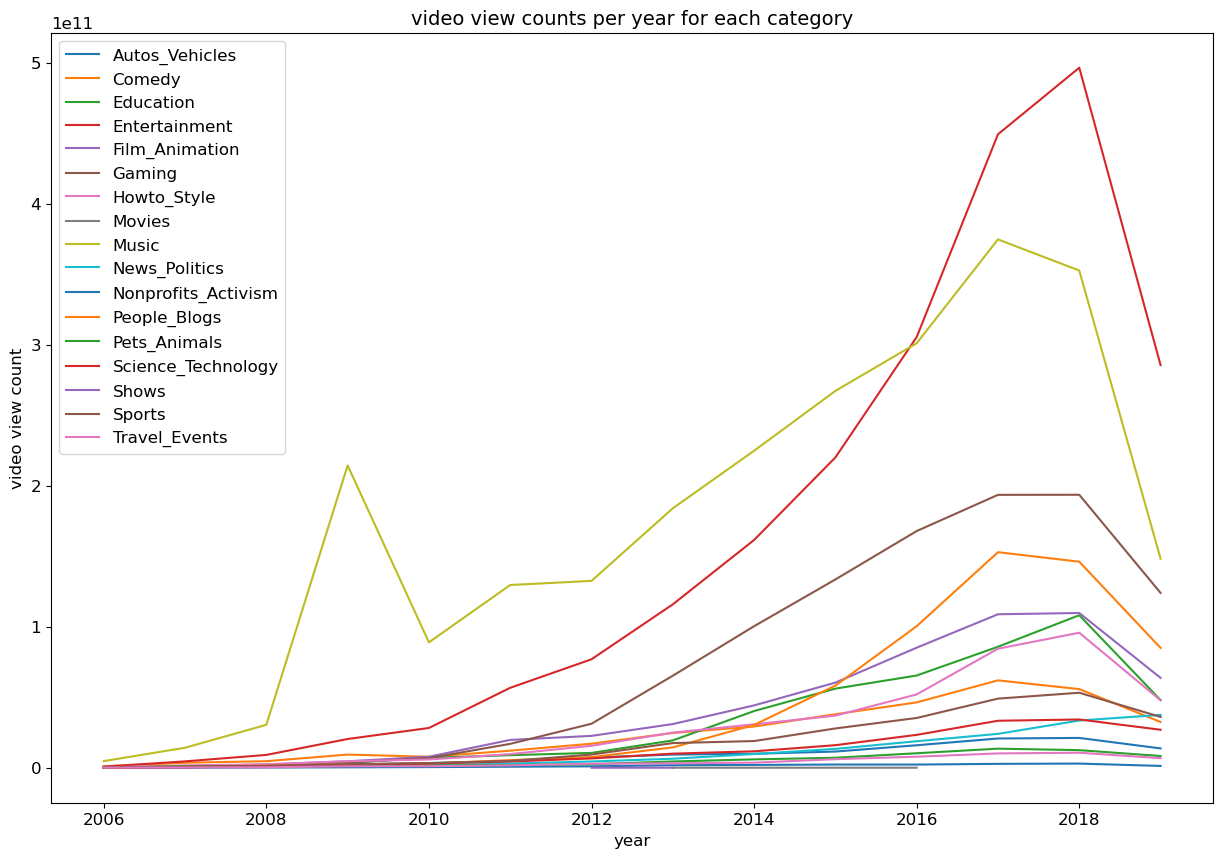

In [34]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video view count")
plt.title("video view counts per year for each category")
plt.show()


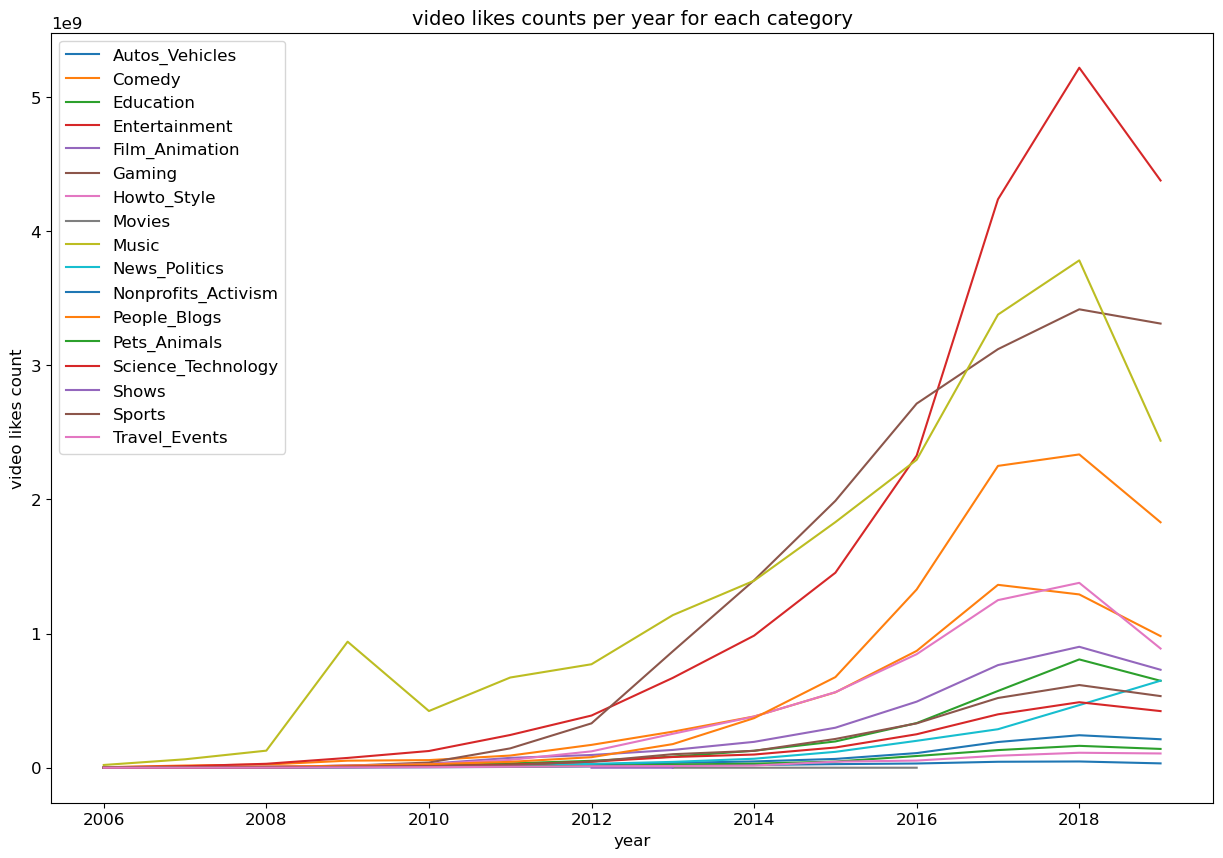

In [35]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:],
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video likes count")
plt.title("video likes counts per year for each category")
plt.show()


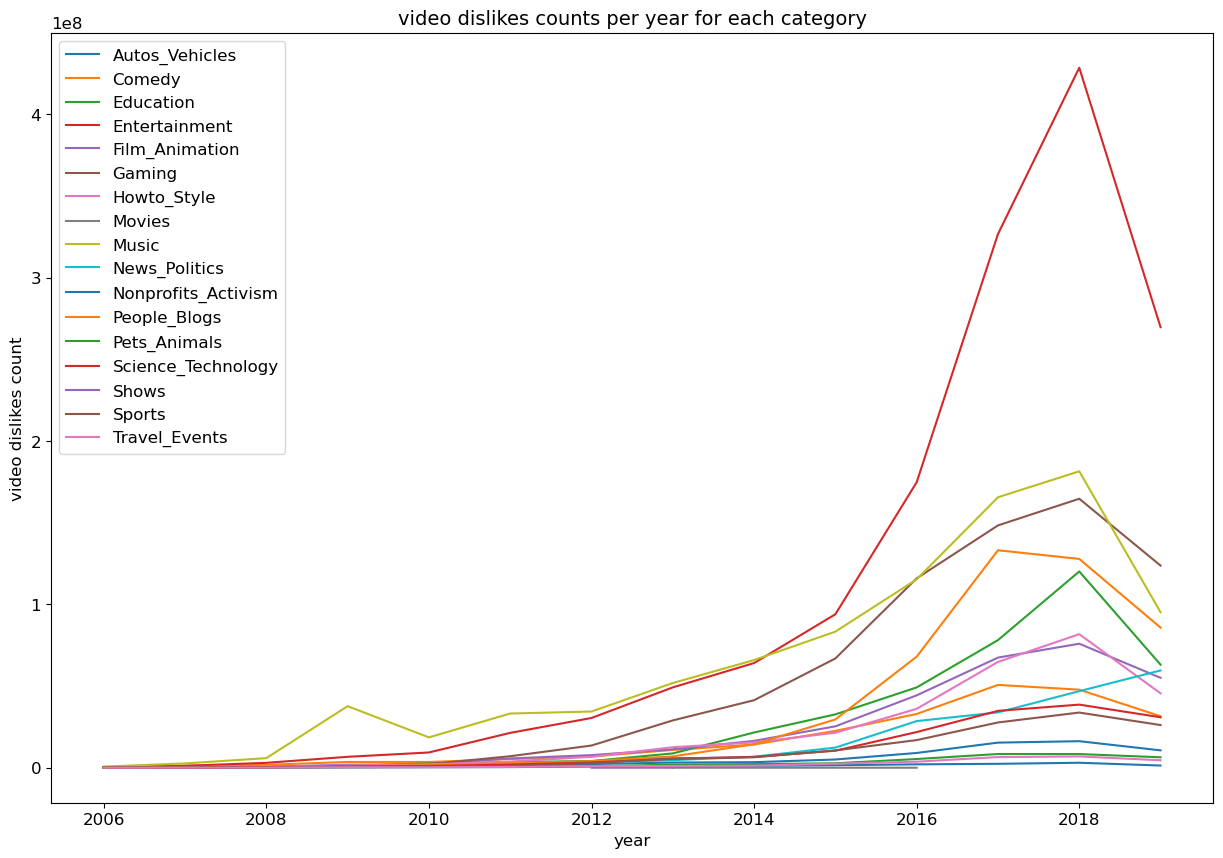

In [36]:
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_dislike_count_by_year.shape[0]):
    plt.plot(
        video_dislike_count_by_year.loc[
            i,
        ][2:],
        label=video_dislike_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("video dislikes count")
plt.title("video dislikes counts per year for each category")
plt.show()


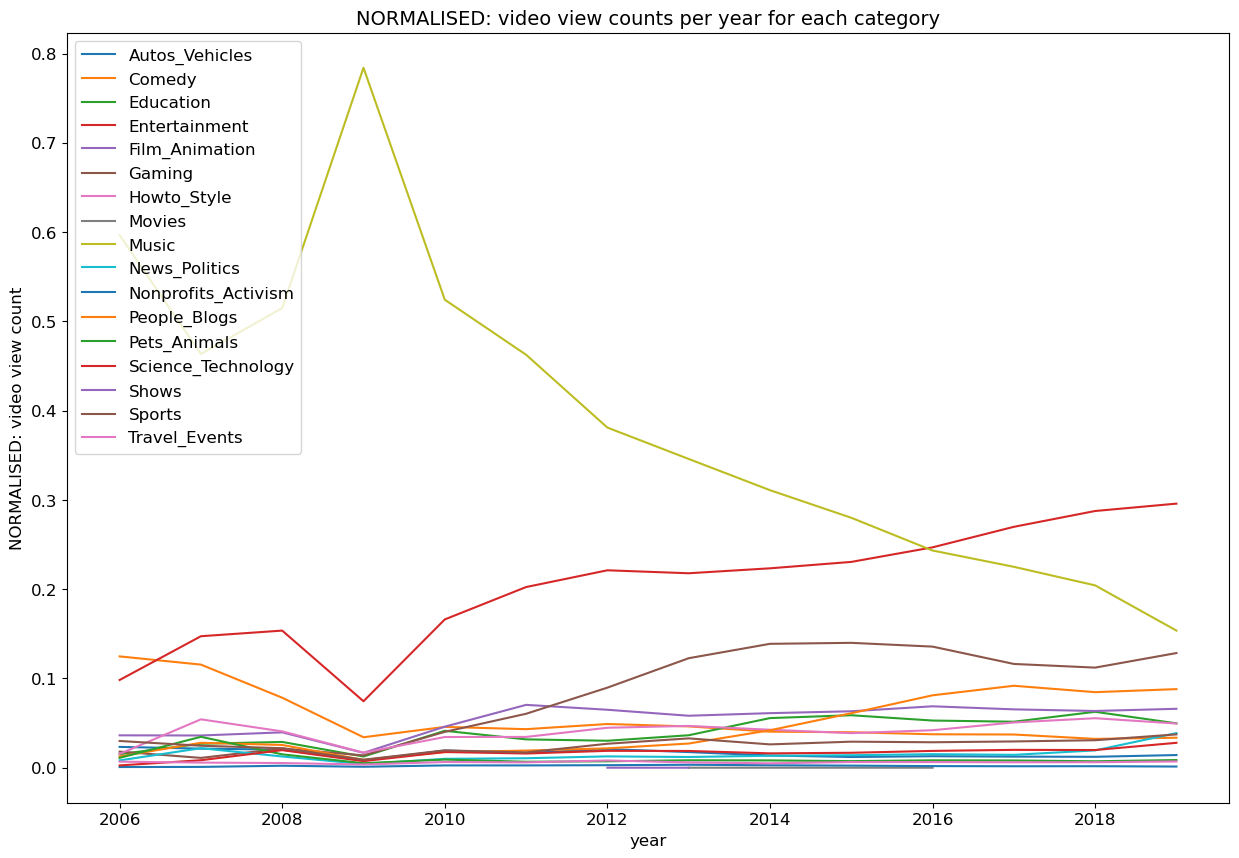

In [37]:
# NORMALISATION:
## 1. view count - normalise wrt. total video views per year, to see which categories is viewed more every year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_view_count_by_year.shape[0]):
    plt.plot(
        video_view_count_by_year.loc[
            i,
        ][2:]
        / video_view_count_by_year.sum(axis=0)[2:],
        label=video_view_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video view count")
plt.title("NORMALISED: video view counts per year for each category")
plt.show()
# view on music videos decreases, whereas on entertainment and gaming increases


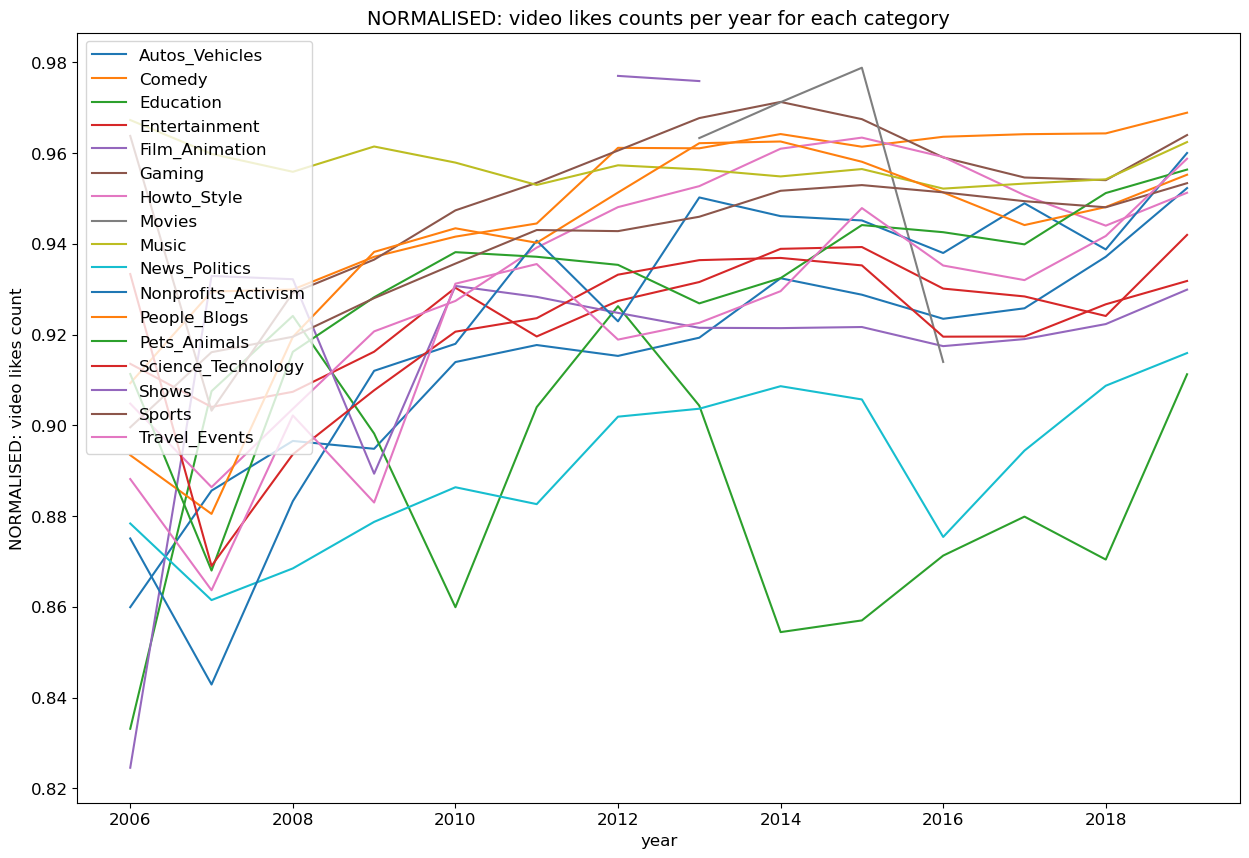

In [38]:
## 2. like count - normalise wrt. total likes+dislikes for that category for that year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_like_count_by_year.loc[
                i,
            ][2:]
            + video_dislike_count_by_year.loc[
                i,
            ][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video likes count")
plt.title("NORMALISED: video likes counts per year for each category")
plt.show()

# now it is interesting to see that news_politics and education are consistantly less liked
# whereas for nonprofits_activism is becoming more loved


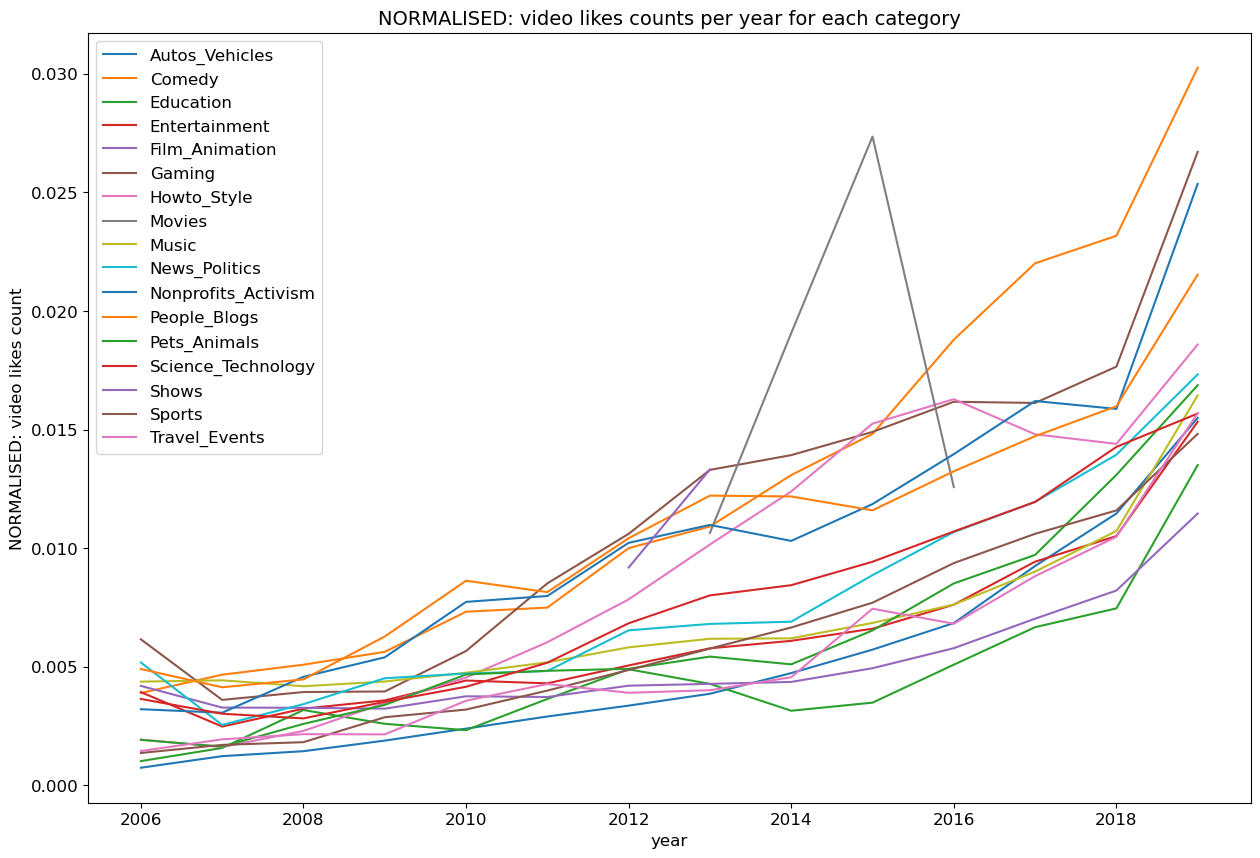

In [39]:
## 2. like count - normalise wrt. total likes+dislikes for that category for that year
plt.rcParams["figure.figsize"] = (15, 10)
for i in np.arange(video_like_count_by_year.shape[0]):
    plt.plot(
        video_like_count_by_year.loc[
            i,
        ][2:]
        / (
            video_view_count_by_year.loc[
                i][2:]
        ),
        label=video_like_count_by_year.loc[i,][
            0:1
        ][0],
    )
plt.legend(loc="upper left")
plt.xlabel("year")
plt.ylabel("NORMALISED: video likes count")
plt.title("NORMALISED: video likes counts per year for each category")
plt.show()

# now it is interesting to see that news_politics and education are consistantly less liked
# whereas for nonprofits_activism is becoming more loved


In [ ]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


In [ ]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


In [ ]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


In [ ]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)


In [ ]:
dfs = []


# Use Least Square to predict the number of views given the category and the date

In [ ]:
def choose_video_metadata_year(year):
    return video_metadatas[video_metadatas["year"] == year]


In [ ]:
video_metadatas["year"] = video_metadatas["upload_date"].dt.year


In [ ]:
video_metadatas.head()


In [ ]:
video_metadatas.columns


In [ ]:
video_metadatas_2005 = choose_video_metadata_year(2005)
video_metadatas_2005.drop(["upload_date", "channel_id"], axis=1, inplace=True)
video_metadatas_2005.head()


In [ ]:
model = smf.ols(
    formula="view_count ~ duration + C(categories)", data=video_metadatas_2005
)

res = model.fit()
print(res.summary())

# print(res.predict([120, 'Music']))


---

In [ ]:
top_ranked_channels = df_channels[df_channels.subscriber_rank_sb < 100]
top_ranked_channels.head()


In [ ]:
date = top_ranked_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
np.mean(date, axis=0)


In [ ]:
oldest_video = df_channels["join_date"].apply(lambda d: d.to_pydatetime().year)
oldest_video.nsmallest(5)


In [ ]:
channels_with_largest_subscribers = df_channels.nlargest(53, "subscribers_cc")
channels_with_largest_subscribers.sample(7)
